# Homework 4
 
Aya Liu

Code from this notebook is included in `main.py` to run in terminal

In [105]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from dateutil import parser

import data_preprocess as preprocess
import pipeline as pp

pd.options.display.max_columns = 999

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model Building

In the pipeline, I ran various models on three training sets to predict whether an educational project is not fully funded within 60 days. Predictions made from the model can be used to target educational projects that are lacking timely funding and provide them with resources.

In [106]:
# Read data
file = 'data/projects_2012_2013.csv'
coltypes = {'school_ncesid': str}
parse_dates = ['date_posted', 'datefullyfunded']
df = pp.read_csv(file, coltypes=coltypes, parse_dates=parse_dates)

In [108]:
# Prepare data
df = preprocess.pre_pipeline_clean(df)

In [109]:
# Construct pipeline
pipeline = pp.Pipeline()

In [139]:
# Set pipeline parameters
label = 'not_funded_wi_60d'
predictor_sets = [['school_city', 'school_state',
       'school_metro', 'school_district', 'school_county', 'school_charter',
       'school_magnet', 'teacher_prefix', 'primary_focus_subject',
       'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area',
       'resource_type', 'poverty_level', 'grade_level',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match']]
time_col = 'date_posted'
start = parser.parse('2012-01-01')
end = parser.parse('2013-12-31')
test_window_months = 6
outcome_lag_days = 60
output_dir = 'output_test_053019'
output_filename = 'evaluations.csv'
ks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [138]:
# Run pipeline on test grid
pipeline.run(df, time_col, predictor_sets, label, start, end, test_window_months, 
            outcome_lag_days, output_dir, output_filename, grid_size='test', thresholds=[], 
            ks=ks, save_output=True, debug=True)

START
GRID SIZE = test
set up done. output: output_small_053019/evaluations.csv
## TRAIN: 2012-01-01 00:00:00 - 2012-06-30 00:00:00, TEST:2012-08-30 00:00:00 - 2013-02-27 00:00:00 ##
### Predictors: ['school_city', 'school_state', 'school_metro', 'school_district', 'school_county', 'school_charter', 'school_magnet', 'teacher_prefix', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level', 'total_price_including_optional_support', 'students_reached', 'eligible_double_your_impact_match']
...train test split done
...pre-processing done
...feature generation done
#### 0-0: RF
{'max_depth': 1, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 1, 'n_jobs': -1}
---model results saved---
#### 0-1: ET
{'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 1, 'n_jobs': -1}
---model results saved---
#### 0-2: AB
{'algorithm': 'SAMME', 'n_estimat

### Comment on grid

I wasn't able to finish running the small grid on a RCC cluster -- I could only build 33 models in 4 hours and it was taking a very long time on GradientBoosting. Therefore, the analysis below is only done using the output generated by the test grid. I am aware that the results are not meaningful, but it shows the processes I will take to evaluate the small grid output if I had them.

### Training and test sets

Each test set is 6 months long (except for the latest one). Between each training and test set there is a 60-day gap, because it takes 60 days to know whether the project posted on the last day of the training set time is fully funded within 60 days or not. That is also the reason why the last test set is 60 days earlier than our data end date 2013-12-31.

In [137]:
for i, (train_start, train_end, test_start, test_end) in enumerate(pipeline.train_test_times):
    print('N = {}'.format(i))
    print('TRAIN: START {} END {}'.format(train_start, train_end))
    print('TEST: START {} END {}\n'.format(test_start, test_end))

N = 0
TRAIN: START 2012-01-01 00:00:00 END 2012-06-30 00:00:00
TEST: START 2012-08-30 00:00:00 END 2013-02-27 00:00:00

N = 1
TRAIN: START 2012-01-01 00:00:00 END 2012-12-29 00:00:00
TEST: START 2013-02-28 00:00:00 END 2013-08-27 00:00:00

N = 2
TRAIN: START 2012-01-01 00:00:00 END 2013-06-28 00:00:00
TEST: START 2013-08-28 00:00:00 END 2013-11-01 00:00:00



## Evalutaion

`pipeline` contains functions to compare model performances.


We mainly care about picking the model with the highest precision given the resource constraint of our intervention, because we want our limited resources to have a high "hit rate" for underfunded projects . 



### Compare precision when we can intervene with 10% most at-risk projects

Given that we can only intervene with 10% of posted projects, we would want the model with the highest precision when we consider only the projects with the 10% highest risk scores as projects that will not be fully funded within 60 days, which are the projects receiving our assistance.

The graph below tells us, among the models we've built, model 0-3, 1-3, and 2-3 (Logistic Regression with C=0.01, penalty=l1) has the highest precision (40%-50%), among which the model trained with the 2nd training set has the highest precision. This means if we use the 

In [148]:
evaluations_filepath = output_dir + '/evaluations.csv' 
k = 0.1

pp.compare_model_precisions_at_k(evaluations_filepath, k,  Ns=[], model_types=[], model_ids=[],
                              save_output=True, output_filepath='compare_at_0.1.png')

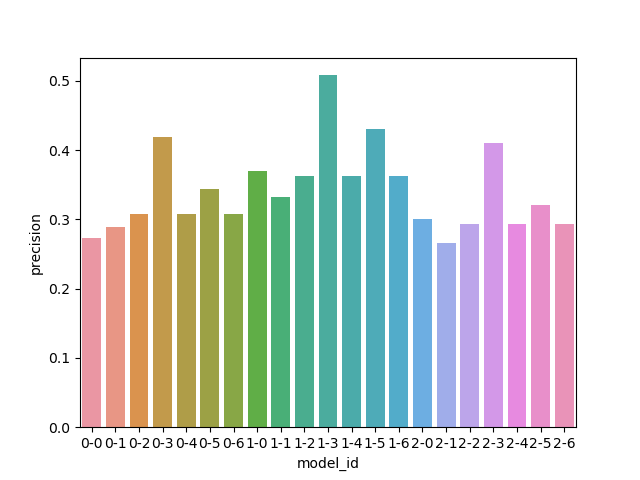

The Average precision of model #3 Logistic Regression (C=0.01, Penalty=L1) from each train/test split is 0.45. That is, on average, 45% of the underfunded projects predicted by this model are actually not fully funded within 60 days.

In [164]:
ev = pd.read_csv(evaluations_filepath)
ev[(ev['i'] == 3) & (ev['k'] == 0.1)]['precision'].mean()

0.4462279730250434

### Compare overall performance of models regardless of intervention resource constraints

If we don't need to adhere to a budget constraint that can only help a certain percentage of the population, we can use the model that has the best overall performance. For this, we look
 at models with the highest AUC scores. These models have the smallest overall false positive rates and false negative rates when we vary thresholds of risk scores above which we consider as underfunded.
 
The graph below tells us, among the models we've built, model 0-3, 1-3, and 2-3 (Logistic Regression with C=0.01, penalty=l1) has the highest AUC score. This is the same model as the one with the highest precision at 10%.

In [160]:
pp.compare_model_aucs(evaluations_filepath, save_output=True, output_filepath='compare_auc.png')

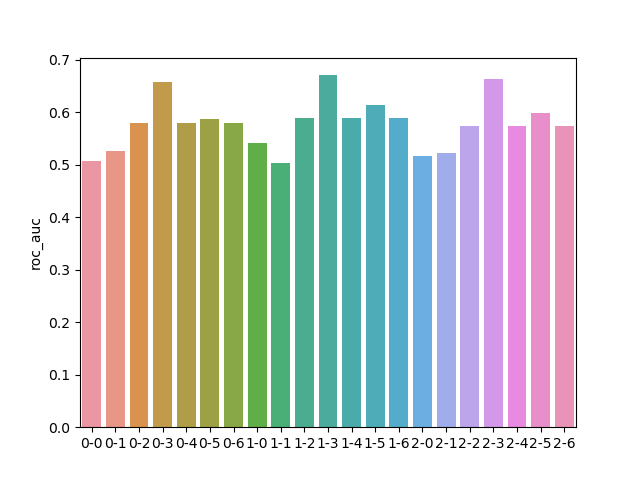

### Precision-Recall Curve for Model 1-3 at k
Projects with the top k(%) highest probability scores of being underfunded are considered to be not fully funded within 60 days.

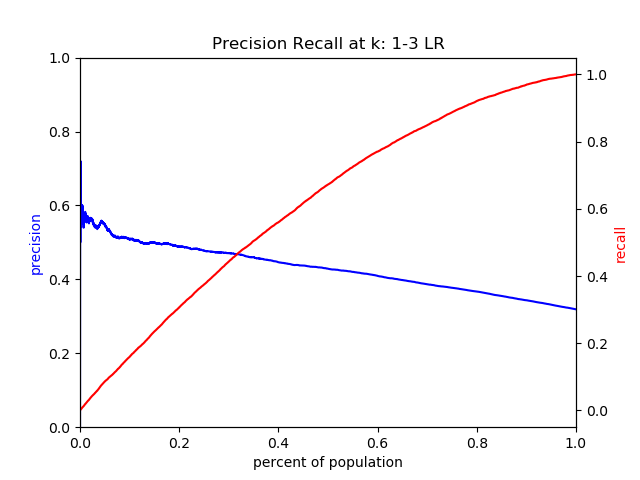